# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-ML-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


# Feature Engineering

Many features have been proposed for Skin lesion classification. Among the most used ones, there is the so-called ABCD rule whose features describie four important characteristics of the skin lesion: Asymmetry, Border irregularity, Colour(and Texture) and Dimension (and Geometry).

To compute these features, you will have at your disposal the *manual segmentation* of the skin lesions and you could follow, for instance, *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

Other works can be found in the literature.

For the ML part, you can use the CPU server (no need for GPU here)

In [1]:
%%capture capt
!pip install scikit-image
!pip install torch torchvision

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import io, color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image


%matplotlib inline

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

You can either download the data from my Google Drive or work locally.

In [3]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
  !mkdir ./data
  gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  !rm -rf ./data/TrainCropped.zip
  !rm -rf ./data/TestCropped.zip
  !rm -rf ./data/ValCropped.zip
  path='./data/'
else:
  print('You are NOT using colab')
  # we assume that folders of data are in the same folder as this jupyter notebook
  path='' # if you change this path , you should also change idTRain, idVal and idTest

You are NOT using colab


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [4]:
IN_COLAB = True

In [5]:
if IN_COLAB:
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  # !rm -rf ./data/TrainCropped.zip
  # !rm -rf ./data/TestCropped.zip
  # !rm -rf ./data/ValCropped.zip
  path='./data/'

Let's load the data.

In [6]:
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
# print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

There are 2000 Train images


In [7]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
#print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [8]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


We can then plot an image with the related mask and contour.

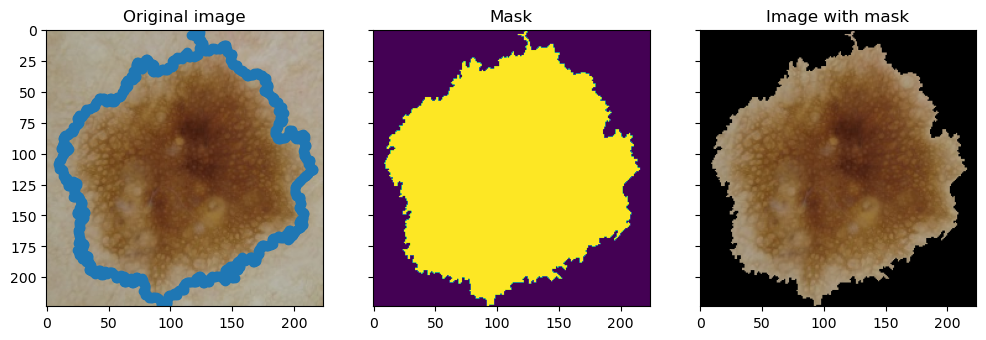

In [9]:
name_im = idTrain[10]
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint16
image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
image_mul_mask = (image_Segmentation_expand*image)
contours = cv2.findContours(image_Segmentation_boolean, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contour = list(contours[0])
contour = np.squeeze(np.asarray(contour))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(image)
grid[0].scatter(contour[:,0],contour[:,1])
#grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(image_Segmentation_boolean)
#grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(image_mul_mask)
#grid[2].axis('off')
grid[2].set_title("Image with mask");

# Manual Feature Engineering

In this part, you will have to manually compute features relevant to the skin lesion classification. You can, for instance, implement the features described in [1] or in other papers.

**TODO**: Implement at least 10 features belonging to at least 3 classes of the ABCD rule, namely:
- Asymmetry
- Border
- Color (and Texture)
- Dimension (and Geometry)

**Please note the overall time (reading papers + implementation + computation) for computing the features. You will need it in the next part of the practical session.**

**This part counts for half of the grade of this TP**

[1] M. Zortea et al. "Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists". Artificial Intelligence in Medicine. 2014

In [10]:
# XXXXXXXXXXXXX
# Add here your code
from numba import njit
from scipy.stats import norm

In [11]:
feature_extraction_methods = {}
nb_features = 0
labels_fe = []

## Asymmetry

In [12]:
#### Compute features (f1, f2) #####
def compute_S1_S2(image, mask):
  area_mask = np.sum(mask)
  S1 = np.sum(np.abs(image - np.fliplr(image)) * mask) / area_mask
  S2 = np.sum(np.abs(image - np.flipud(image)) * mask) / area_mask
  return S1, S2

def rotate_image(image, angle):
  return np.array(Image.fromarray(image).rotate(angle))

def asymmetry_shape(image, mask):
  gray_scale = rgb2gray(image)
  best_scores = None
  best_average_score = float('inf')

  for rotation_angle in range(0, 360, 10):
    rotated_image = rotate_image(gray_scale, rotation_angle)
    S1, S2 = compute_S1_S2(rotated_image, mask)
    average_score = (S1+S2)/2

    if average_score < best_average_score:
      best_average_score = average_score
      best_scores = (S1, S2) if S1 <= S2 else (S2, S1)
  return best_scores

feature_extraction_methods[1] = asymmetry_shape
nb_features += 2
labels_fe += ['f1_asym', 'f2_asym']

## Border

In [13]:
##### Compute f7, f8, f9 #####

def find_contour(mask):
    contour, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contour = np.squeeze(np.asarray(contour))
    return contour

@njit # compiling with numba grants us a faster computation time
def compute_metrics(window, X1, X2):
    def mean_(X):
        if len(X) <= 0:
            return 0
        return np.mean(X)
        
    mean_X = mean_(window)
    mean_X1 = mean_(X1)
    mean_X2 = mean_(X2)

    sse = np.sum((X1 - mean_X) ** 2) + np.sum((X2 - mean_X) ** 2)
    ssr = len(X1) * (mean_X1 - mean_X) ** 2 + len(X2) * (mean_X2 - mean_X) ** 2

    sst = sse + ssr
    if sst == 0:
        return 0
    R = sse / sst
    return R

def calculate_R(image, mask, i, j, window_size=61):
    half_window = window_size // 2    
    left = max(0, i - half_window)
    right = min(i + half_window + 1, len(image))
    up = max(0, j - half_window)
    down = min(j + half_window + 1, image.shape[1])
    
    # Extract the window centered at pixel (i, j)
    window = image[left: right, up: down]
    # Extract corresponding regions from the mask
    mask_inside = mask[left: right, up: down]

    # Points inside the window and inside the mask (X1)
    X1 = window[mask_inside == 1]
    # Points inside the window but outside the mask (X2)
    X2 = window[mask_inside == 0]

    R = compute_metrics(window, X1, X2)
    return R

def ANOVA_based_metrics(image, mask):
    gray_image = rgb2gray(image)
    contour, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = np.squeeze(np.concatenate([x for x in contour]))
    R_values = []
    for border_point in contour:
        i, j = border_point
        R_values.append(calculate_R(gray_image, mask, i, j, window_size=61))

    f7 = np.percentile(R_values, 25)
    f8 = np.percentile(R_values, 50)
    f9 = np.percentile(R_values, 75)
    return f7, f8, f9

feature_extraction_methods[4] = ANOVA_based_metrics
nb_features += 3
labels_fe += ['f7_border', 'f8_border', 'f9_border']

## Color/Texture

In [14]:
##### Compute f3, f4 #####
from sklearn.neighbors import KernelDensity

def estimate_distribution(image):
  image_flat = image.flatten()

  # Fit Gaussian Kernel Density Estimation
  kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
  kde.fit(image_flat[:, np.newaxis])

  # Generate values for the estimated distribution (C)
  gray_values = np.linspace(0, 255, 256).reshape(-1, 1)
  log_dens = kde.score_samples(gray_values)

  # Convert log densities to actual densities
  C = np.exp(log_dens)
  return C

def compute_C1_C2(gray_image, mask):
  gray_scale_masked_im = gray_image * mask
  height, width = gray_scale_masked_im.shape
  C_A1_A2 = estimate_distribution(gray_scale_masked_im[:height//2, :])
  C_A3_A4 = estimate_distribution(gray_scale_masked_im[height//2:, :])
  C_A1_A4 = estimate_distribution(gray_scale_masked_im[:, width//2:])
  C_A2_A3 = estimate_distribution(gray_scale_masked_im[:, :width//2])
  C1 = np.sum(abs(C_A1_A2 - C_A3_A4))
  C2 = np.sum(abs(C_A1_A4 - C_A2_A3))
  return C1, C2

def asymmetry_color_intensity(image, mask):
  gray_image = rgb2gray(image)
  best_scores = None
  best_average_score = float('inf')

  for rotation_angle in range(0, 360, 10):
    rotated_image = rotate_image(gray_image, rotation_angle)
    C1, C2 = compute_C1_C2(rotated_image, mask)
    average_score = (C1+C2)/2
    if average_score < best_average_score:
      best_average_score = average_score
      best_scores = (C1, C2) if C1 <= C2 else (C2, C1)
  return best_scores

feature_extraction_methods[2] = asymmetry_color_intensity
nb_features += 2
labels_fe += ['f3_color', 'f4_color']

In [15]:
##### Compute features f5, f6 #####
from scipy.ndimage import center_of_mass

def asymmetry_shape_color(image, mask):
  center = center_of_mass(mask)
  gray_scale_masked_im = rgb2gray(image) * mask

  alternative_centers = []
  for t in range(10, 100, 10):
      threshold_value = np.percentile(gray_scale_masked_im, t)
      alternative_mask = (gray_scale_masked_im > threshold_value).astype(int)
      alternative_centers.append(center_of_mass(alternative_mask))

  v = [np.linalg.norm(np.array(center) - np.array(alt_center)) for alt_center in alternative_centers]
  radius = np.sqrt(np.sum(mask) / np.pi)
  v /= radius
  return np.mean(v), np.std(v)

feature_extraction_methods[3] = asymmetry_shape_color
nb_features += 2
labels_fe += ['f5_color', 'f6_color']

In [16]:
##### Compute f10, f11, f12 #####
def rgb_to_lab(image):
    # Convert RGB image to CIE L*a*b* color space
    lab_image =  color.rgb2lab(image)
    return lab_image

def compute_color_features(image, mask): #mask is not used here, but left in parameters for consistency
  num_samples=10000
  bin_size=2
  random_indices = np.random.choice(image.shape[0] * image.shape[1], num_samples, replace=False)
  sampled_pixels = image.reshape(-1, 3)[random_indices]

  lab_pixels = rgb_to_lab(sampled_pixels.reshape(-1, 1, 3))

  # Flatten the 3D array to get L*, a*, b* values
  lab_values = lab_pixels.reshape(-1, 3)

  hist, edges = np.histogramdd(lab_values,
                                bins=(np.arange(0, 100+bin_size, bin_size),
                                      np.arange(-127, 127+bin_size, bin_size),
                                      np.arange(-127, 127+bin_size, bin_size)))

  nb_non_empty_bins = 0
  avg_samples_per_bin = 0
  indices_non_empty = []
  for i in range(len(hist)):
    if len(np.unique(hist[i])) > 1: #non-empty bin
      indices_non_empty.append(i)
      nb_non_empty_bins += 1
      non_zero_samples = (hist[i] != 0).sum()
      avg_samples_per_bin += non_zero_samples

  total_nb_bins = len(hist)
  avg_samples_per_bin /= total_nb_bins
  bin_variance = np.var(hist[indices_non_empty])
  pct_non_empty_bins = nb_non_empty_bins / total_nb_bins
  return avg_samples_per_bin, bin_variance, pct_non_empty_bins

feature_extraction_methods[5] = compute_color_features
nb_features += 3
labels_fe += ['f10_color', 'f11_color', 'f12_color']

In [17]:
##### Compute f13, f14, f15, f16, f17, f18 #####
def shrink_contour(mask, contour):
    kernel = np.ones((3, 3), dtype=np.uint8)
    shrunken_mask = cv2.erode(mask, kernel, iterations=1)
    shrunken_contour, _ = cv2.findContours(shrunken_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shrunken_contour = np.squeeze(np.concatenate([x for x in shrunken_contour]))
    return shrunken_mask, shrunken_contour

def peripheral_vs_central(image, mask):
    shrunken_mask = mask.copy()
    contour, _ = cv2.findContours(shrunken_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = np.squeeze(np.concatenate([x for x in contour]))
    while shrunken_mask.sum() / mask.sum() > 0.7:
        shrunken_mask, contour = shrink_contour(shrunken_mask, contour)
        
    outside_region_lab = rgb_to_lab(image * np.expand_dims(mask - shrunken_mask, axis=2))
    inside_region_lab = rgb_to_lab(image * np.expand_dims(shrunken_mask, axis=2))
    f13 = abs(np.mean(inside_region_lab[:, :, 0]) - np.mean(outside_region_lab[:, :, 0]))
    f14 = abs(np.mean(inside_region_lab[:, :, 1]) - np.mean(outside_region_lab[:, :, 1]))
    f15 = abs(np.mean(inside_region_lab[:, :, 2]) - np.mean(outside_region_lab[:, :, 2]))
    
    def compute_density(channel_values):
        return norm.pdf(channel_values, loc=np.mean(channel_values), scale=np.std(channel_values))

    density_inner_L = compute_density(inside_region_lab[:, :, 0])
    density_outer_L = compute_density(outside_region_lab[:, :, 0])
    f16 = np.sum(np.minimum(density_inner_L, density_outer_L))  # Overlapping area for L channel

    density_inner_a = compute_density(inside_region_lab[:, :, 1])
    density_outer_a = compute_density(outside_region_lab[:, :, 1])
    f17 = np.sum(np.minimum(density_inner_a, density_outer_a))  # Overlapping area for a channel

    density_inner_b = compute_density(inside_region_lab[:, :, 2])
    density_outer_b = compute_density(outside_region_lab[:, :, 2])
    f18 = np.sum(np.minimum(density_inner_b, density_outer_b))  # Overlapping area for b channel

    return f13, f14, f15, f16, f17, f18

feature_extraction_methods[6] = peripheral_vs_central
nb_features += 6
labels_fe += ['f13_texture', 'f14_texture', 'f15_texture', 'f16_texture', 'f17_texture', 'f18_texture']

## Dimension/Geometry

In [18]:
##### Compute features f21, f22, f23 #####
from skimage import filters, morphology, measure

def compute_lesion_pieces(image, mask, opening_radius=5):
  gray_lesion_image = rgb2gray(image) * mask
  lesion_pieces = []

  for percentile_value in [25, 50, 75]:
    threshold_value = np.percentile(gray_lesion_image, percentile_value)
    binary_mask = gray_lesion_image > threshold_value

    # Morphological opening to reduce noise
    footprint = morphology.disk(opening_radius)
    binary_mask_opened = morphology.binary_opening(binary_mask, footprint)

    # Label connected components to count the number of pieces
    labeled_mask = measure.label(binary_mask_opened)
    num_pieces = np.max(labeled_mask)
    lesion_pieces.append(num_pieces)

  return lesion_pieces

feature_extraction_methods[7] = compute_lesion_pieces
nb_features += 3
labels_fe += ['f21_texture', 'f22_texture', 'f23_texture']

## Create and store extracted features

In [19]:
import multiprocessing
from multiprocessing import Pool
import time

In [20]:
feature_extraction_methods = dict(sorted(feature_extraction_methods.items())) # sort the dictionary by key

In [21]:
import re

def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

# we use this bit of code to sort the labels
labels_fe = sorted(labels_fe, key=extract_number)
print(labels_fe)

['f1_asym', 'f2_asym', 'f3_color', 'f4_color', 'f5_color', 'f6_color', 'f7_border', 'f8_border', 'f9_border', 'f10_color', 'f11_color', 'f12_color', 'f13_texture', 'f14_texture', 'f15_texture', 'f16_texture', 'f17_texture', 'f18_texture', 'f21_texture', 'f22_texture', 'f23_texture']


In [22]:
print(f'We will extract {nb_features}')
print(f'Using these methods: {feature_extraction_methods}')

We will extract 21
Using these methods: {1: <function asymmetry_shape at 0x7f765a1a8040>, 2: <function asymmetry_color_intensity at 0x7f7659439630>, 3: <function asymmetry_shape_color at 0x7f7659439cf0>, 4: <function ANOVA_based_metrics at 0x7f765a1a80d0>, 5: <function compute_color_features at 0x7f7659439c60>, 6: <function peripheral_vs_central at 0x7f765943a5f0>, 7: <function compute_lesion_pieces at 0x7f7659477370>}


In [23]:
def get_image_mask(set_, index, path=path):
  if set_ == 'Train':
    idSet = idTrain
  elif set_ == 'Test':
    idSet = idTest
  else:
    idSet = idVal

  name_im = idSet[index]
  filename = path + f'{set_}Cropped/{name_im}.jpg'
  image = imread(filename)

  filename_Segmentation = path + f'{set_}Cropped/{name_im}seg.png'
  image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
  mask = (image_Segmentation/255).astype(np.uint8) # To get uint16
  return image, mask

def process_array(indices, set_, feature_extraction_methods=feature_extraction_methods, nb_features=nb_features):
  X_fe = np.zeros((len(indices), nb_features))
  for index in indices:
    image, mask = get_image_mask(set_, index, path=path)

    cur_feature = 0
    for key, method in feature_extraction_methods.items():
      features = method(image, mask)
      for feature in features:
        X_fe[index-indices[0]][cur_feature] = feature
        cur_feature += 1
  return X_fe

In [24]:
def process_features_multiprocessing(set_, nb_cpu, feature_extraction_methods=feature_extraction_methods, nb_features=nb_features):
  if set_ == 'Train':
    idSet = idTrain
  elif set_ == 'Test':
    idSet = idTest
  else:
    idSet = idVal

  linspace_ = [int(round(x, 0)) for x in np.linspace(0, len(idSet), nb_cpu+1)]
  indices = [list(range(linspace_[i], linspace_[i+1])) for i in range(nb_cpu)]

  X_fe = np.zeros((len(idSet), nb_features))
  with Pool(nb_cpu) as p:
    async_results = [p.apply_async(process_array,
                                   args=(indices[i], set_, feature_extraction_methods, nb_features)) for i in range(nb_cpu)]

    for i in range(len(indices)):
      X_fe[indices[i]] = async_results[i].get()
  return X_fe

In [25]:
nb_cpu = multiprocessing.cpu_count()
print(f'There are {nb_cpu} cpu cores available.')
start = time.time()
Xtrain_fe = process_features_multiprocessing('Train', nb_cpu)
Xtest_fe = process_features_multiprocessing('Test', nb_cpu)
Xval_fe = process_features_multiprocessing('Val', nb_cpu)
stop = time.time()

There are 104 cpu cores available.


In [26]:
minutes, seconds = divmod(stop-start, 60)
formatted_time = "{:02}:{:02}".format(int(minutes), int(seconds))
print(f'It took {formatted_time} to extract all the features for the train/val/test datasets')

It took 10:51 to extract all the features for the train/val/test datasets


# Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [27]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [28]:
Ytrain=np.zeros(len(idTrain))
for i in range(len(idTrain)):
  name=idTrain[i]
  index=Groundtrain["image_id"].str.find(name)
  max_index = index.argmax()
  Ytrain[i]=int(Groundtrain["melanoma"][max_index])

In [29]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

In [30]:
Yval=np.zeros(len(idVal))
for i in range(len(idVal)):
  name=idVal[i]
  index=Groundval["image_id"].str.find(name)
  max_index = index.argmax()
  Yval[i]=int(Groundval["melanoma"][max_index])

In [31]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [32]:
Ytest=np.zeros(len(idTest))
for i in range(len(idTest)):
  name=idTest[i]
  index=Groundtest["image_id"].str.find(name)
  max_index = index.argmax()
  Ytest[i]=int(Groundtest["melanoma"][max_index])

## Standard Machine Learning Prediction

In this part, you will use standard ML algorithms (such as logistic regression, SVM and Random Forests) on the features you previously computed.
Before starting, you should look at the data and check the proportion of classes.
Two hints:
- in sklearn you can use *class_weight='balanced'* when calling a ML method
- it exists a very interesting library called *imblearn* (e.g., from imblearn.over_sampling import ADASYN)

In [33]:
np.random.seed(seed=666)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

**Pre-trained features**: for the next part, you can either use your own features or download a pre-computed set of features.

In [34]:
labels=['f1_asym','f2_asym','f5_asym','f6_asym','f7_bord','f8_bord','f9_bord','f10_color','f11_color','f12_color','f13_color','f14_color',
        'f15_color','f16_color','f17_color','f18_color','meanR','stdR','meanG','stdG','meanB','stdB','maxR','maxG','maxB','Area','Ecc', 
        'Diam','Ratio','Perim','f21_geom','f22_geom','f23_geom']

In [35]:
Xtrain_dw=np.load('./X_train_eng.npy')
Xtest_dw=np.load('./X_test_eng.npy')
Xval_dw=np.load('./X_val_eng.npy')

N,M=Xtrain_dw.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(Ytrain), np.sum(Ytrain)))

Number of images: 2000; Number of features per image: 33
Number of healthy nevus: 1626.0; Number of melanoma: 374.0


In [36]:
# XXXXXXXXXXXXX
# Add here your code
l, c = np.unique(Ytrain, return_counts=True)
print(f"There are {c[0]} elements in class {int(l[0])} and {c[1]} elements in class {int(l[1])}.")

There are 1626 elements in class 0 and 374 elements in class 1.


In [37]:
def cm_cr(clf, Xtrain, Xtest, Ytrain, Ytest):
  pred = clf.predict(Xtest)
  pred_train = clf.predict(Xtrain)
  train_acc, test_acc = accuracy_score(Ytrain, pred_train), accuracy_score(Ytest, pred)
  train_balanced_acc, test_balanced_acc = balanced_accuracy_score(Ytrain, pred_train), balanced_accuracy_score(Ytest, pred)
  print(f"Train accuracy: {round(100*train_acc, 2)}%, Train balanced accuracy: {round(100*train_balanced_acc, 2)}%")
  print(f"Test  accuracy: {round(100*test_acc, 2)}%, Test  balanced accuracy: {round(100*test_balanced_acc, 2)}%\n")
  print(classification_report(Ytest, pred, labels=clf.classes_))
  cm = confusion_matrix(Ytest, pred, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
  disp.plot()

# ML models

## Balanced Random Forest

In [38]:
from imblearn.ensemble import BalancedRandomForestClassifier
from itertools import product
from tqdm import tqdm
import time

In [39]:
def grid_search(params_list, classifier, Xtrain, Ytrain, Xtest, Ytest, cv=2):
  best_bal_accuracy = 0.0
  accuracies, bal_accuracies = [], []
  best_params = None

  if not isinstance(params_list, list):
    params_list = [params_list]

  for params in params_list:
    for param_values in tqdm(list(product(*params.values()))):
        param_dict = dict(zip(params.keys(), param_values))

        accuracy, bal_accuracy = 0, 0
        for _ in range(cv):
          clf = classifier(**param_dict)
          clf.fit(Xtrain, Ytrain)
          y_pred = clf.predict(Xtest)
          accuracy += accuracy_score(Ytest, y_pred)
          bal_accuracy += balanced_accuracy_score(Ytest, y_pred)
        accuracy /= cv
        accuracies.append(accuracy)
        bal_accuracy /= cv
        bal_accuracies.append(bal_accuracy)

        if bal_accuracy > best_bal_accuracy:
            best_bal_accuracy = bal_accuracy
            best_params = param_dict

  # Print the best parameters and corresponding accuracy
  print("\nBest Parameters:", best_params)
  print("Best Balanced Accuracy:", round(100*best_bal_accuracy, 2))
  return best_params, accuracies, bal_accuracies

def plot_accuracies(accuracies, bal_accuracies, suptitle=''):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  axs[0].scatter(range(len(accuracies)), accuracies)
  axs[0].set_title('Accuracy')
  axs[1].scatter(range(len(bal_accuracies)), bal_accuracies)
  axs[1].set_title('Balanced Accuracy')
  plt.suptitle(suptitle)
  plt.tight_layout()
  plt.show()

In [40]:
def run_balanced_random_forest(Xtrain, Ytrain, Xtest, Ytest, plot_=True):
  start = time.time()
  params = {
    'n_estimators': list(range(1000, 0, -200)),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(2, 22, 4)),
    'sampling_strategy': ['all', 1/4],
    'replacement': [True, False],
      'n_jobs': [-1]
  }

  best_params, accuracies, bal_accuracies = grid_search(params, BalancedRandomForestClassifier, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest, cv=2)
  if plot_:
    plot_accuracies(accuracies, bal_accuracies, suptitle='Balanced Random Forest')
  balanced_rf = BalancedRandomForestClassifier(**best_params)
  balanced_rf.fit(Xtrain, Ytrain)
  print()
  cm_cr(balanced_rf, Xtrain, Xtest, Ytrain, Ytest)
  stop = time.time()
  return balanced_rf, best_params, stop-start

## Gradient Boosting

In [41]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [42]:
def run_grad_boosting(Xtrain, Ytrain, Xtest, Ytest, plot_=True):
  start = time.time()
  params = {
    'learning_rate': [1e-1, 1e-2, 1e-3],
    'max_iter': [500],
    'max_leaf_nodes': list(range(5, 45, 10)),
    'max_depth': [None] + list(range(2, 22, 4)),
    'l2_regularization': np.linspace(0, 1, 5),
    'early_stopping': [True],
    'validation_fraction': [0.15]
  }

  best_params, accuracies, bal_accuracies = grid_search(params, HistGradientBoostingClassifier, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest, cv=2)
  if plot_:
    plot_accuracies(accuracies, bal_accuracies, suptitle='Gradient Boosting')
  boost = HistGradientBoostingClassifier(**best_params)
  boost.fit(Xtrain, Ytrain)
  print()
  cm_cr(boost, Xtrain, Xtest, Ytrain, Ytest)
  stop = time.time()
  return boost, best_params, stop-start

## Logistic regression

In [43]:
def run_logistic_regression(Xtrain, Ytrain, Xtest, Ytest, plot_=True):
  start = time.time()
  params = [{'solver': ['lbfgs'], 'penalty': ['l2'], 'C': np.logspace(-4, 4, 40), 'max_iter': [10_000]},
              {'solver': ['lbfgs'], 'penalty': [None], 'max_iter': [10_000]},
          ]

  best_params, accuracies, bal_accuracies = grid_search(params, LogisticRegression, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest, cv=2)
  if plot_:
    plot_accuracies(accuracies, bal_accuracies, suptitle='Logistic Regression')
  lr = LogisticRegression(**best_params)
  lr.fit(Xtrain, Ytrain)
  print()
  cm_cr(lr, Xtrain, Xtest, Ytrain, Ytest)
  stop = time.time()
  return lr, best_params, stop-start

## k-Nearest Centroid/Neighbor

In [44]:
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier

In [45]:
def run_knc(Xtrain, Ytrain, Xtest, Ytest, plot_=True):
  start = time.time()
  params = {'metric': ['euclidean', 'manhattan'],
          'shrink_threshold': np.linspace(0.1, 500, 500)}

  best_params, accuracies, bal_accuracies = grid_search(params, NearestCentroid, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest, cv=2)
  if plot_:
    plot_accuracies(accuracies, bal_accuracies, suptitle='Nearest Centroid')
  knc = NearestCentroid(**best_params)
  knc.fit(Xtrain, Ytrain)
  print()
  cm_cr(knc, Xtrain, Xtest, Ytrain, Ytest)
  stop = time.time()
  return knc, best_params, stop-start

In [46]:
def run_knn(Xtrain, Ytrain, Xtest, Ytest, plot_=True):
  start = time.time()
  params = {
    'n_neighbors': list(range(1, 23, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
  }

  best_params, accuracies, bal_accuracies = grid_search(params, KNeighborsClassifier, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest, cv=2)
  if plot_:
    plot_accuracies(accuracies, bal_accuracies, suptitle='k-Nearest Neighbor')
  knn = KNeighborsClassifier(**best_params)
  knn.fit(Xtrain, Ytrain)
  print()
  cm_cr(knn, Xtrain, Xtest, Ytrain, Ytest)
  stop = time.time()
  return knn, best_params, stop-start

# Run models

## Scale data

In [47]:
def scale_data(Xtrain, Xtest):
  scaler = StandardScaler()
  scaler.fit(Xtrain)
  Xtrain_scaled = scaler.transform(Xtrain)
  Xtest_scaled = scaler.transform(Xtest)
  return Xtrain_scaled, Xtest_scaled

## Over-sample data

In [48]:
%%capture capt
!pip install -U imbalanced-learn

In [49]:
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE

In [50]:
def over_sample_data(Xtrain, Ytrain, Xtest, method=SMOTE):
  X_os, y_os = method().fit_resample(Xtrain, Ytrain)
  l, c = np.unique(y_os, return_counts=True)
  print(f"There are {c[0]} elements in class {int(l[0])} and {c[1]} elements in class {int(l[1])} after over-sampling.")
  X_os_scaled, X_test_scaled = scale_data(X_os, Xtest)
  return X_os_scaled, y_os, X_test_scaled

# Downloaded features

In [51]:
Xtrain_dw_scaled, Xtest_dw_scaled = scale_data(Xtrain_dw, Xtest_dw)

In [52]:
Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os = over_sample_data(Xtrain_dw, Ytrain, Xtest_dw, method=SMOTE)

There are 1626 elements in class 0 and 1626 elements in class 1 after over-sampling.


100%|██████████| 240/240 [37:50<00:00,  9.46s/it] 



Best Parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 6, 'sampling_strategy': 'all', 'replacement': True, 'n_jobs': -1}
Best Balanced Accuracy: 52.78


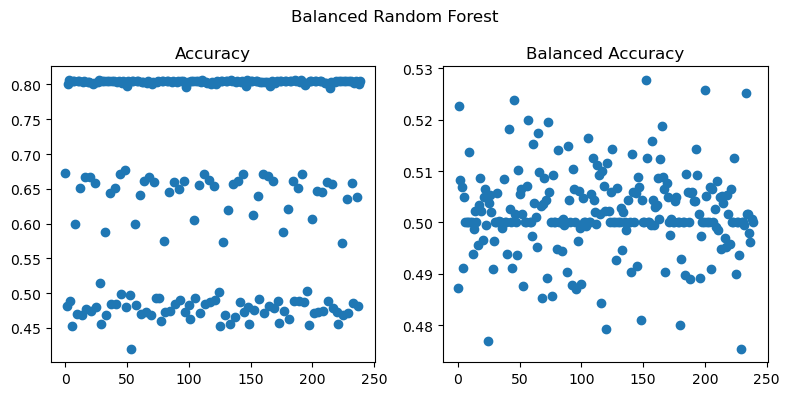


Train accuracy: 83.55%, Train balanced accuracy: 86.28%
Test  accuracy: 58.0%, Test  balanced accuracy: 50.92%

              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71       483
         1.0       0.20      0.39      0.27       117

    accuracy                           0.58       600
   macro avg       0.51      0.51      0.49       600
weighted avg       0.69      0.58      0.62       600



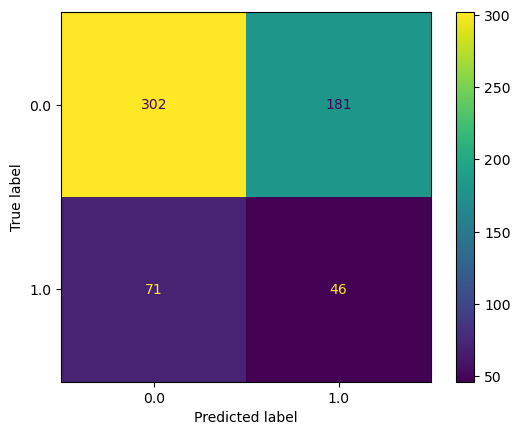

In [53]:
balanced_rf, best_params_rf, time_rf = run_balanced_random_forest(Xtrain_dw_scaled, Ytrain, Xtest_dw_scaled, Ytest, plot_=True)

100%|██████████| 360/360 [13:45<00:00,  2.29s/it]



Best Parameters: {'learning_rate': 0.001, 'max_iter': 500, 'max_leaf_nodes': 35, 'max_depth': 2, 'l2_regularization': 0.0, 'early_stopping': True, 'validation_fraction': 0.15}
Best Balanced Accuracy: 56.72


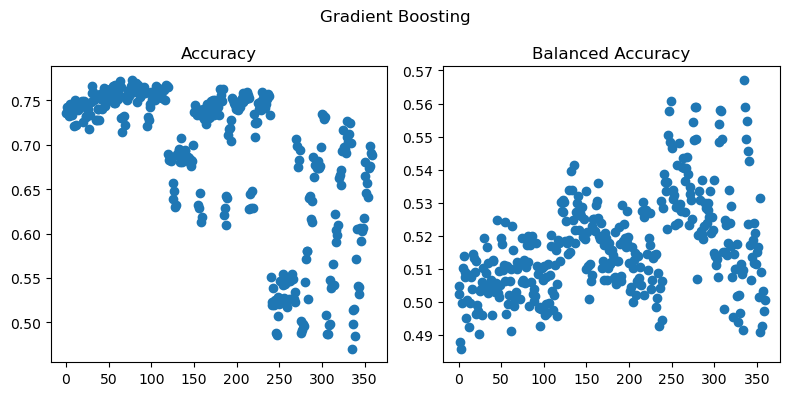


Train accuracy: 62.33%, Train balanced accuracy: 62.33%
Test  accuracy: 49.83%, Test  balanced accuracy: 54.92%

              precision    recall  f1-score   support

         0.0       0.84      0.47      0.60       483
         1.0       0.22      0.63      0.33       117

    accuracy                           0.50       600
   macro avg       0.53      0.55      0.46       600
weighted avg       0.72      0.50      0.55       600



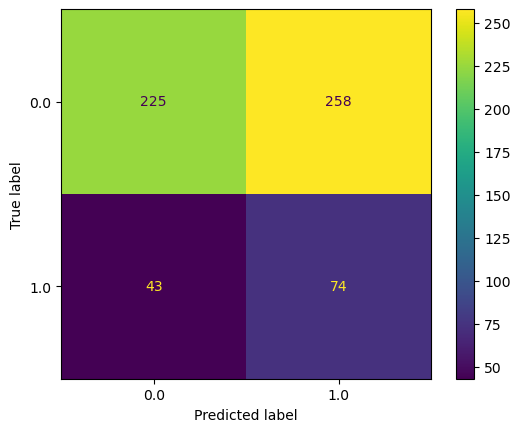

In [54]:
boost, best_params_boost, time_boost = run_grad_boosting(Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, plot_=True)

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 9.999999999999999e-05, 'max_iter': 10000}
Best Balanced Accuracy: 55.39


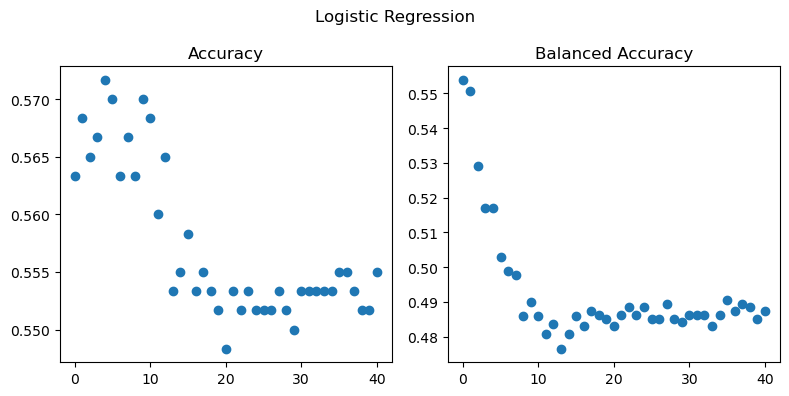


Train accuracy: 52.64%, Train balanced accuracy: 52.64%
Test  accuracy: 56.33%, Test  balanced accuracy: 55.39%

              precision    recall  f1-score   support

         0.0       0.84      0.57      0.68       483
         1.0       0.23      0.54      0.32       117

    accuracy                           0.56       600
   macro avg       0.53      0.55      0.50       600
weighted avg       0.72      0.56      0.61       600



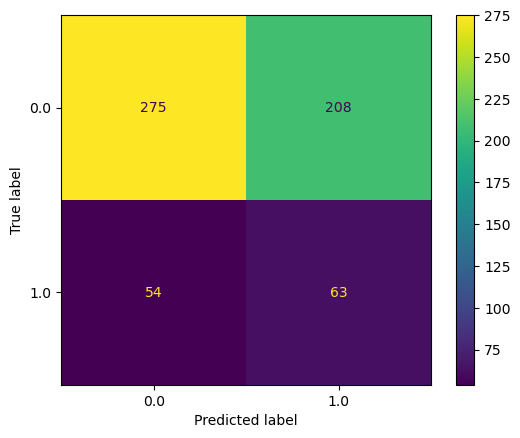

In [55]:
lr, best_params_lr, time_lr = run_logistic_regression(Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, plot_=True)

100%|██████████| 1000/1000 [00:12<00:00, 81.03it/s]



Best Parameters: {'metric': 'euclidean', 'shrink_threshold': 1.1018036072144288}
Best Balanced Accuracy: 54.45


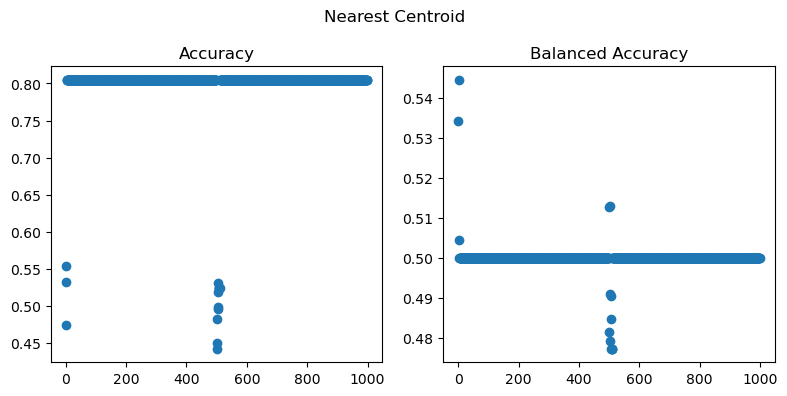


Train accuracy: 52.24%, Train balanced accuracy: 52.24%
Test  accuracy: 55.33%, Test  balanced accuracy: 54.45%

              precision    recall  f1-score   support

         0.0       0.83      0.56      0.67       483
         1.0       0.23      0.53      0.32       117

    accuracy                           0.55       600
   macro avg       0.53      0.54      0.49       600
weighted avg       0.71      0.55      0.60       600



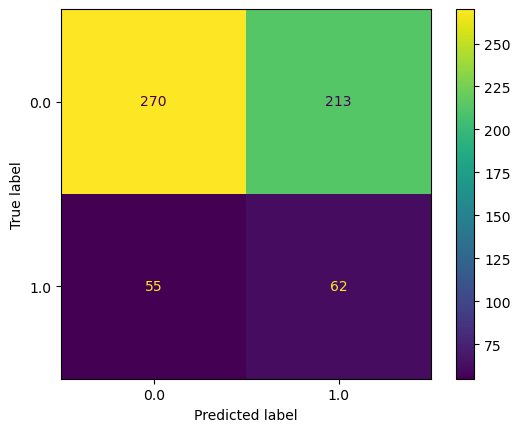

In [56]:
knc, best_params_knc, time_knc = run_knc(Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, plot_=True)

100%|██████████| 132/132 [00:07<00:00, 17.44it/s]



Best Parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1, 'metric': 'euclidean'}
Best Balanced Accuracy: 52.36


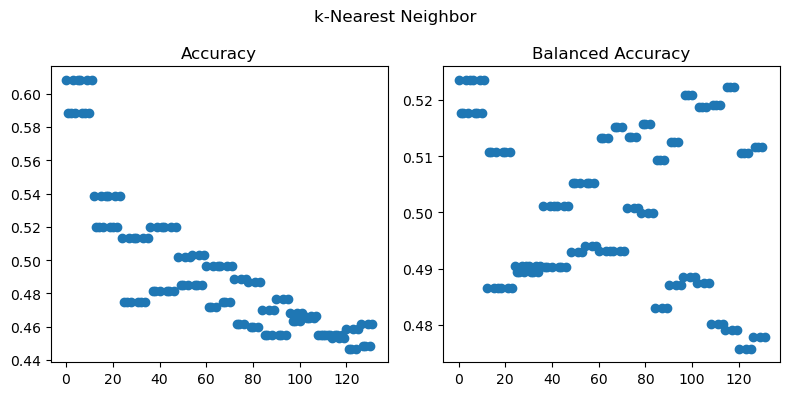


Train accuracy: 100.0%, Train balanced accuracy: 100.0%
Test  accuracy: 60.83%, Test  balanced accuracy: 52.36%

              precision    recall  f1-score   support

         0.0       0.82      0.66      0.73       483
         1.0       0.22      0.38      0.28       117

    accuracy                           0.61       600
   macro avg       0.52      0.52      0.50       600
weighted avg       0.70      0.61      0.64       600



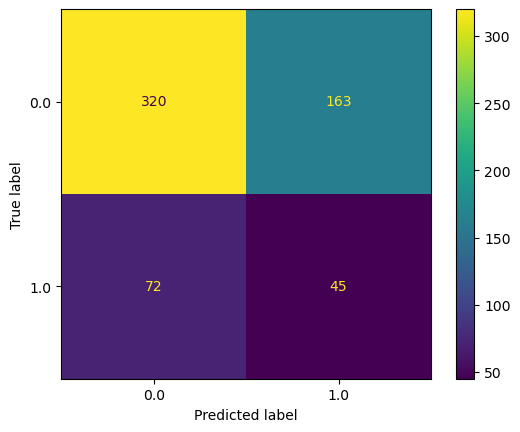

In [57]:
knn, best_params_knn, time_knn = run_knn(Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, plot_=True)

In [58]:
def summarize(df, model, Xtrain, Ytrain, Xtest, Ytest, time_):
  r = lambda x: round(x, 3)
  pred = model.predict(Xtest)
  pred_train = model.predict(Xtrain)
  train_acc, test_acc = r(accuracy_score(Ytrain, pred_train)), r(accuracy_score(Ytest, pred))
  train_balanced_acc, test_balanced_acc = r(balanced_accuracy_score(Ytrain, pred_train)), r(balanced_accuracy_score(Ytest, pred))
  minutes, seconds = divmod(time_, 60)
  formatted_time = "{:02}:{:02}".format(int(minutes), int(seconds))
  row = {'model': model.__str__().split('(')[0], 'Train accuracy': train_acc, 'Test accuracy': test_acc,
         'Train balanced accuracy': train_balanced_acc, 'Test balanced accuracy': test_balanced_acc, 'time CV+train': formatted_time}
  return df._append(row, ignore_index=True)

summary_dw = pd.DataFrame(columns=['model', 'Train accuracy', 'Train balanced accuracy', 'Test accuracy', 'Test balanced accuracy',  'time CV+train'])
summary_dw = summarize(summary_dw, balanced_rf, Xtrain_dw_scaled, Ytrain, Xtest_dw_scaled, Ytest, time_rf)
summary_dw = summarize(summary_dw, boost, Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, time_boost)
summary_dw = summarize(summary_dw, lr, Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, time_lr)
summary_dw = summarize(summary_dw, knc, Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, time_knc)
summary_dw = summarize(summary_dw, knn, Xtrain_dw_os, Ytrain_dw_os, Xtest_dw_os, Ytest, time_knn)
print('Downloaded features')
summary_dw

Downloaded features


,model,Train accuracy,Train balanced accuracy,Test accuracy,Test balanced accuracy,time CV+train
0,BalancedRandomForestClassifier,0.836,0.863,0.580,0.509,37:53
1,HistGradientBoostingClassifier,0.623,0.623,0.498,0.549,13:45
2,LogisticRegression,0.526,0.526,0.563,0.554,00:19
3,NearestCentroid,0.522,0.522,0.553,0.544,00:13
4,KNeighborsClassifier,1.000,1.000,0.608,0.524,00:08


# Manually engineed featured

In [59]:
Xtrain_fe_scaled, Xtest_fe_scaled = scale_data(Xtrain_fe, Xtest_fe)

In [60]:
Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os = over_sample_data(Xtrain_fe, Ytrain, Xtest_fe, method=SMOTE)

There are 1626 elements in class 0 and 1626 elements in class 1 after over-sampling.


100%|██████████| 240/240 [39:08<00:00,  9.79s/it] 



Best Parameters: {'n_estimators': 600, 'criterion': 'entropy', 'max_depth': None, 'sampling_strategy': 'all', 'replacement': True, 'n_jobs': -1}
Best Balanced Accuracy: 62.4


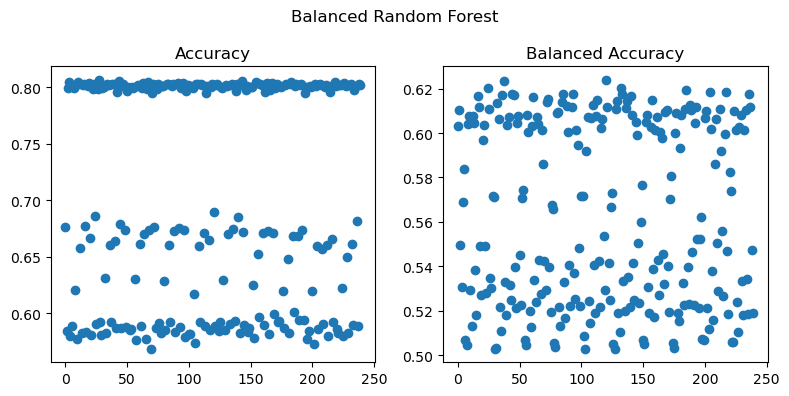


Train accuracy: 92.55%, Train balanced accuracy: 95.42%
Test  accuracy: 67.33%, Test  balanced accuracy: 61.25%

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78       483
         1.0       0.30      0.51      0.38       117

    accuracy                           0.67       600
   macro avg       0.58      0.61      0.58       600
weighted avg       0.75      0.67      0.70       600



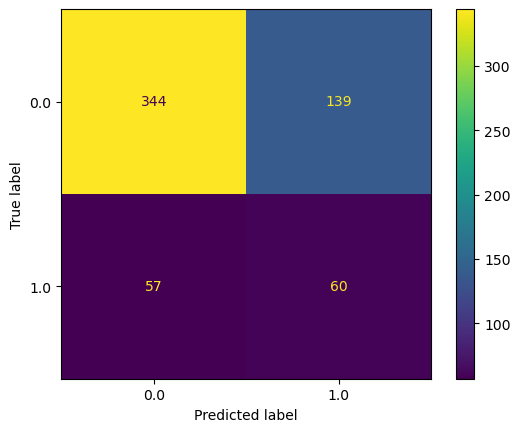

In [61]:
balanced_rf_fe, best_params_rf, time_rf = run_balanced_random_forest(Xtrain_fe_scaled, Ytrain, Xtest_fe_scaled, Ytest, plot_=True)

100%|██████████| 360/360 [13:18<00:00,  2.22s/it]



Best Parameters: {'learning_rate': 0.01, 'max_iter': 500, 'max_leaf_nodes': 5, 'max_depth': 10, 'l2_regularization': 0.25, 'early_stopping': True, 'validation_fraction': 0.15}
Best Balanced Accuracy: 60.52


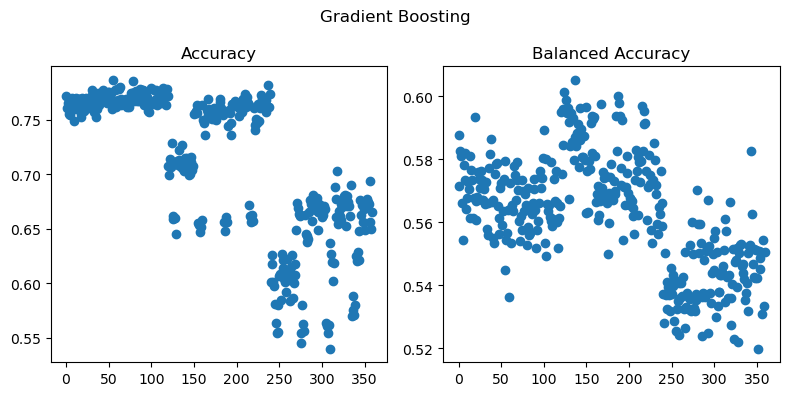


Train accuracy: 81.4%, Train balanced accuracy: 81.4%
Test  accuracy: 71.33%, Test  balanced accuracy: 59.2%

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       483
         1.0       0.31      0.39      0.35       117

    accuracy                           0.71       600
   macro avg       0.58      0.59      0.58       600
weighted avg       0.74      0.71      0.73       600



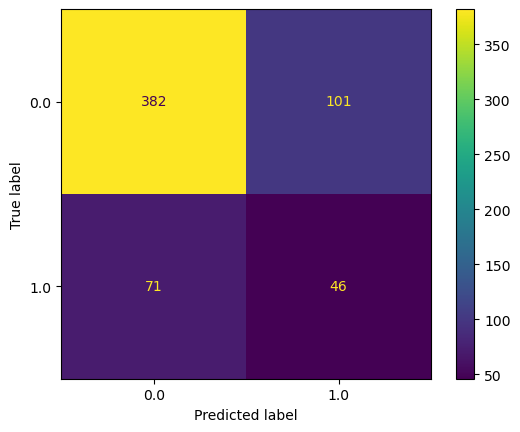

In [62]:
boost_fe, best_params_boost, time_boost = run_grad_boosting(Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, plot_=True)

100%|██████████| 1/1 [00:00<00:00,  9.76it/s]



Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.4923882631706737, 'max_iter': 10000}
Best Balanced Accuracy: 61.16


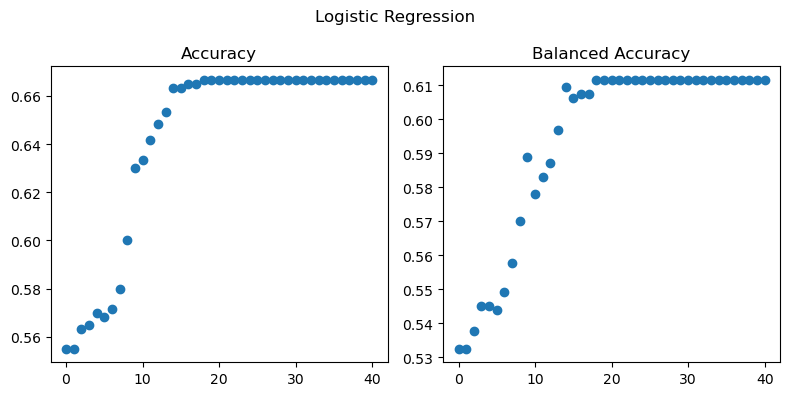


Train accuracy: 67.5%, Train balanced accuracy: 67.5%
Test  accuracy: 66.67%, Test  balanced accuracy: 61.16%

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77       483
         1.0       0.30      0.52      0.38       117

    accuracy                           0.67       600
   macro avg       0.58      0.61      0.58       600
weighted avg       0.75      0.67      0.70       600



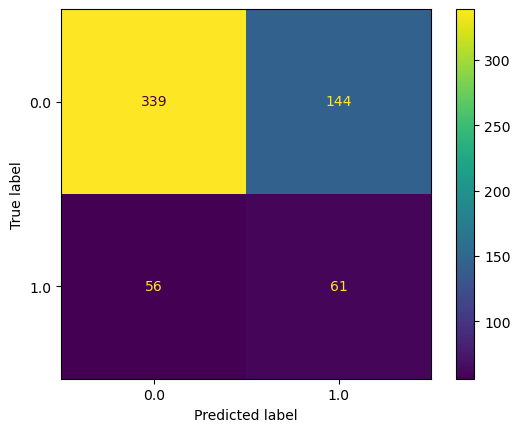

In [63]:
lr_fe, best_params_lr, time_lr = run_logistic_regression(Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, plot_=True)

100%|██████████| 1000/1000 [00:12<00:00, 83.23it/s]



Best Parameters: {'metric': 'manhattan', 'shrink_threshold': 2.1036072144288576}
Best Balanced Accuracy: 59.47


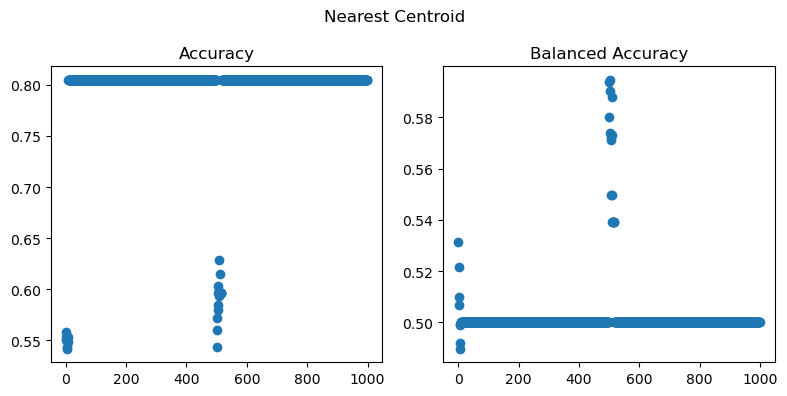


Train accuracy: 62.95%, Train balanced accuracy: 62.95%
Test  accuracy: 57.17%, Test  balanced accuracy: 59.47%

              precision    recall  f1-score   support

         0.0       0.86      0.56      0.68       483
         1.0       0.26      0.63      0.37       117

    accuracy                           0.57       600
   macro avg       0.56      0.59      0.52       600
weighted avg       0.74      0.57      0.62       600



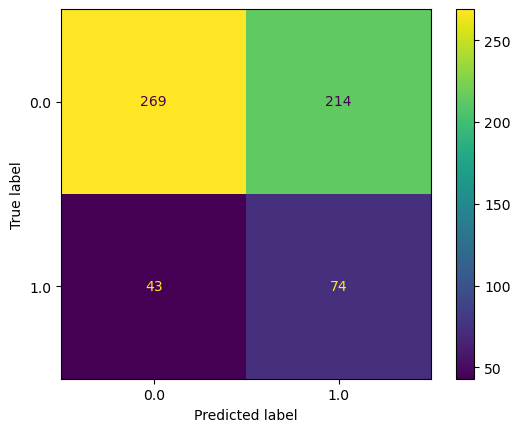

In [64]:
knc_fe, best_params_knc, time_knc = run_knc(Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, plot_=True)

100%|██████████| 132/132 [00:05<00:00, 23.08it/s]



Best Parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1, 'metric': 'manhattan'}
Best Balanced Accuracy: 59.48


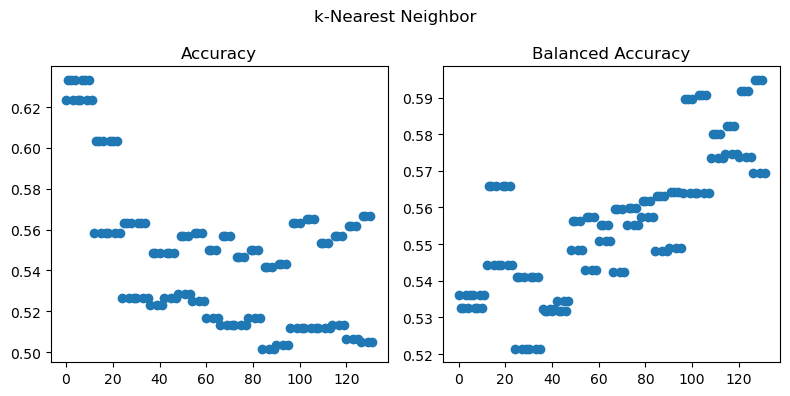


Train accuracy: 100.0%, Train balanced accuracy: 100.0%
Test  accuracy: 56.67%, Test  balanced accuracy: 59.48%

              precision    recall  f1-score   support

         0.0       0.86      0.55      0.67       483
         1.0       0.26      0.64      0.37       117

    accuracy                           0.57       600
   macro avg       0.56      0.59      0.52       600
weighted avg       0.74      0.57      0.61       600



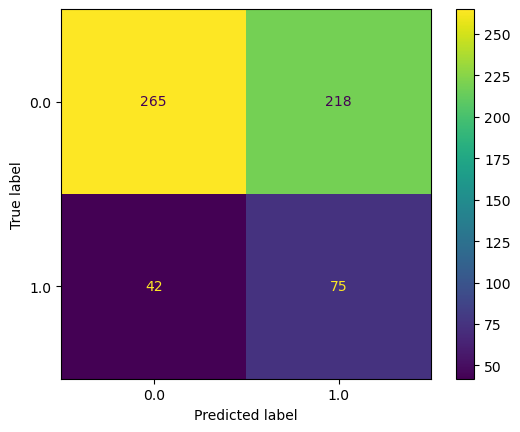

In [65]:
knn_fe, best_params_knn, time_knn = run_knn(Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, plot_=True)

In [66]:
def summarize(df, model, Xtrain, Ytrain, Xtest, Ytest, time_):
  r = lambda x: round(x, 3)
  pred = model.predict(Xtest)
  pred_train = model.predict(Xtrain)
  train_acc, test_acc = r(accuracy_score(Ytrain, pred_train)), r(accuracy_score(Ytest, pred))
  train_balanced_acc, test_balanced_acc = r(balanced_accuracy_score(Ytrain, pred_train)), r(balanced_accuracy_score(Ytest, pred))
  minutes, seconds = divmod(time_, 60)
  formatted_time = "{:02}:{:02}".format(int(minutes), int(seconds))
  row = {'model': model.__str__().split('(')[0], 'Train accuracy': train_acc, 'Test accuracy': test_acc,
         'Train balanced accuracy': train_balanced_acc, 'Test balanced accuracy': test_balanced_acc, 'time CV+train': formatted_time}
  return df._append(row, ignore_index=True)

summary_fe = pd.DataFrame(columns=['model', 'Train accuracy', 'Train balanced accuracy', 'Test accuracy', 'Test balanced accuracy',  'time CV+train'])
summary_fe = summarize(summary_fe, balanced_rf_fe, Xtrain_fe_scaled, Ytrain, Xtest_fe_scaled, Ytest, time_rf)
summary_fe = summarize(summary_fe, boost_fe, Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, time_boost)
summary_fe = summarize(summary_fe, lr_fe, Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, time_lr)
summary_fe = summarize(summary_fe, knc_fe, Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, time_knc)
summary_fe = summarize(summary_fe, knn_fe, Xtrain_fe_os, Ytrain_fe_os, Xtest_fe_os, Ytest, time_knn)
print('Manually extracted features')
summary_fe

Manually extracted features


,model,Train accuracy,Train balanced accuracy,Test accuracy,Test balanced accuracy,time CV+train
0,BalancedRandomForestClassifier,0.925,0.954,0.673,0.613,39:14
1,HistGradientBoostingClassifier,0.814,0.814,0.713,0.592,13:19
2,LogisticRegression,0.675,0.675,0.667,0.612,00:05
3,NearestCentroid,0.629,0.629,0.572,0.595,00:12
4,KNeighborsClassifier,1.000,1.000,0.567,0.595,00:06


**Question**: An important point in medical imaging is the explicability. Can you find the most important and discriminative features ? If yes, how ? Hint: random forest has a very interesting function...  

In [67]:
from sklearn.inspection import permutation_importance

In [68]:
# XXXXXXXXXXXXX
# Add here your code

def feature_importance(model, labels, Xtest, Ytest, title):
  result = permutation_importance(model, Xtest, Ytest, n_repeats=10, n_jobs=-1)
  forest_importances = pd.Series(result.importances_mean, index=labels)
  fig, ax = plt.subplots(figsize=(12, 8))
  forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
  ax.set_title("Feature importances - " + title)
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

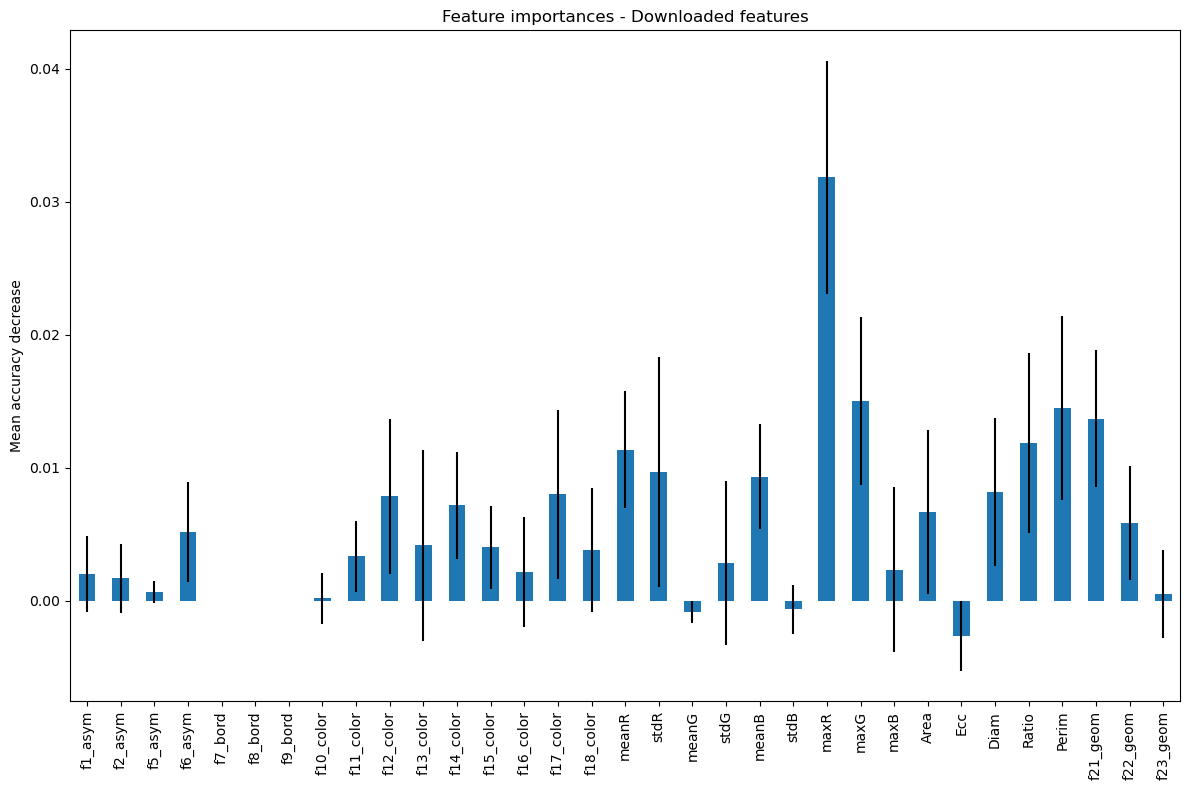

In [73]:
best_model_dw = lr
feature_importance(best_model_dw, labels, Xtest_dw_os, Ytest, 'Downloaded features')

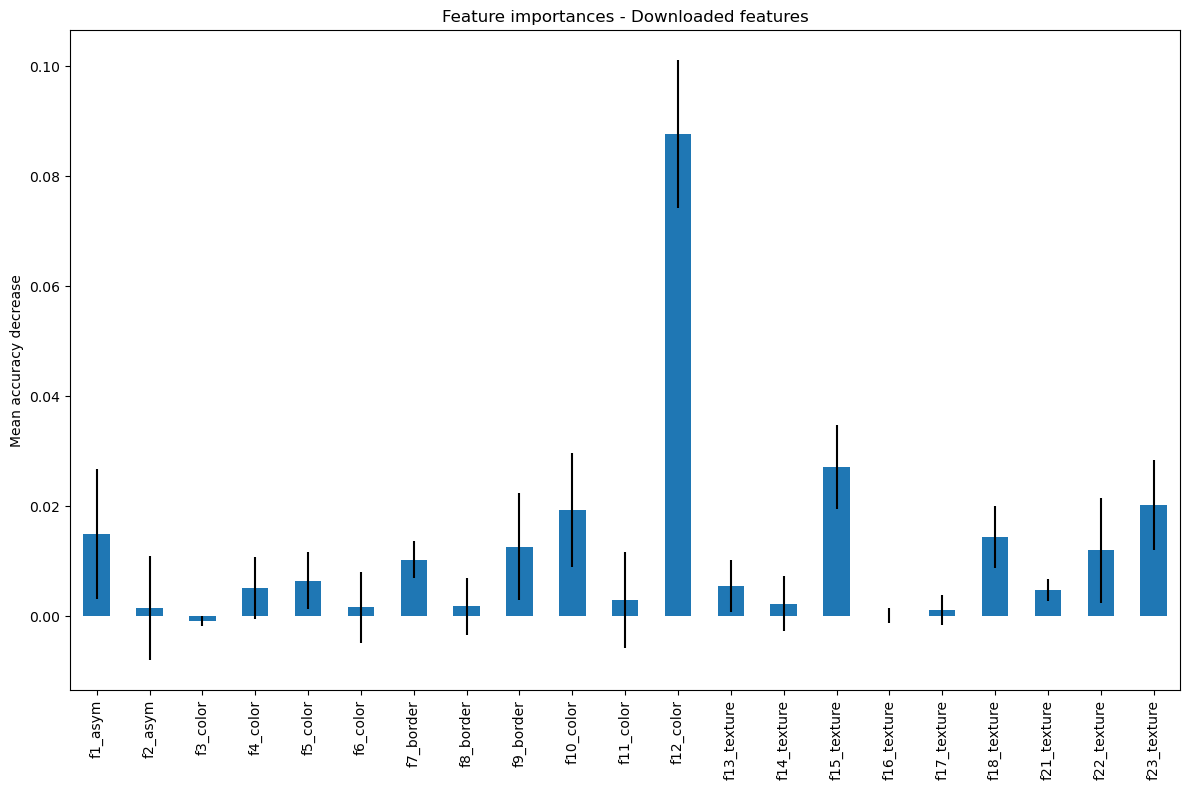

In [75]:
best_model_fe = lr_fe #balanced_rf_fe
feature_importance(best_model_fe, labels_fe, Xtest_fe_os, Ytest, 'Downloaded features')

In [85]:
from sklearn.metrics import roc_auc_score

dw_AUC = roc_auc_score(Ytest, best_model_dw.predict_proba(Xtest_dw_os)[:, 1])
fe_AUC = roc_auc_score(Ytest, best_model_fe.predict_proba(Xtest_fe_os)[:, 1])

print(f'AUC of best model for downloaded featrures: {dw_AUC}')
print(f'AUC of best model for manually extracted features: {fe_AUC}')

AUC of best model for downloaded featrures: 0.5447788926049795
AUC of best model for manually extracted features: 0.6594645290297464


Now you should have a final ML model with a generalization performance on the Test Set.

**Question**: Are you satisfied ? How long did it take to compute and evaluate the manually engineered features ? If you are not satisfied, what are the main problems ? Besides Deep Learning, could you do something to improve the results (if you had more time?)

It took a very long time to perform all the steps:
- ~5 hours to read the papers about feature extraction and implement the methods
- ~10-15 minutes to actually extract the features, using the methods coded previously. I was able to use multiprocessing to parallelize the feature extraction and considerably speed things up.
- ~1 hour to research what ML models to apply, what hyperparameters to tune and actually code everything
- ~1 hour to run the different hyperparameters tuning for the different models and fit them on the two datasets

Deep learning often outperforms manual feature extraction for several reasons:

1. **Automatic Feature Learning:** Deep learning models automatically learn hierarchical and abstract features from raw data, eliminating the need for manual engineering, but also allowing the model to learn features or detect patterns withing the data that we may not have noticed, enabling the model to learn more important elements to classify the data.

2. **Adaptability to Data:** Manual feature extraction may not capture the full complexity of the data, especially in cases where the relationships are non-linear or involve high-dimensional interactions.

3. **End-to-End Learning:** Deep learning optimizes the entire pipeline from input to output, discovering the most relevant representations for the task.

4. **Large Amounts of Data:**
  Deep learning models can leverage pre-trained models on large datasets and fine-tune them for specific tasks. Transfer learning allows models to benefit from knowledge learned on one task and apply it to a related task, even with limited labeled data. <br>
  Manual feature extraction may not easily incorporate knowledge from other domains or tasks, making it harder to transfer learning.

5. **Transfer Learning:** Deep learning leverages pre-trained models and transfers knowledge from related tasks, enhancing performance with limited labeled data.

6. **Model Complexity:** Deep learning models can represent highly complex functions, capturing intricate relationships that may be challenging for manually designed features.


Besides Deep Learning, to try and improve the classification results, we could do:

- **Feature Engineering Refinement:**<br>
Continue refining and expanding our manual feature engineering, experimenting with different feature combinations and extraction techniques, and incorporating more domain-specific knowledge to enhance feature representation.
- **More thorough Hyperparameter Tuning**
- **Imbalances handling**: <br>
Research different approaches to deal with the imbalances in the dataset.
- **Data Augmentation:** although will require even more time to compute the new feature extractions on the augmented images.

However, it feels like we will reach a ceiling much more quickly with these methods, than with Deep Learning.